In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/swiftai")' SwiftAI

Installing packages:
	.package(path: "/home/mlk/swift/swiftai")
		SwiftAI
With SwiftPM flags: []
Working in: /tmp/tmp1a_nc1y6/swift-install
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swiftc: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swiftc)
/home/mlk/swift/usr/bin/swiftc: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no v

In [2]:
import SwiftAI
import TensorFlow
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")

In [3]:
import Foundation
import Just
import Path

In [4]:
let d = mnistDataBunch(path: Path.home/"swift", flat: true, bs: 64)

In [5]:
d.train.ds.first(where: { _ in true })!.xb.shape

▿ [64, 784]
  ▿ dimensions : 2 elements
    - 0 : 64
    - 1 : 784


In [6]:
//MLP model with 2 hidden layers
public struct MyModel: Layer {
    public var hidden1: FADense<Float>
    public var hidden2: FADense<Float>
    public var out:     FADense<Float>
    
    public init(nIn: Int, nHid: Int, nOut: Int){
        hidden1 = FADense(nIn, nHid, activation: relu)
        hidden2 = FADense(nHid, nHid, activation: relu)
        out =     FADense(nHid, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return out(hidden2(hidden1(input)))
    }
}


In [7]:
func modelInit() -> MyModel { return MyModel(nIn: 784,nHid: 512, nOut: 10) }

In [8]:
// Source: http://cs231n.github.io/neural-networks-3/#sgd

public extension StateKeys {
    static let prevGrad = "previousAverageGrad"
}

public struct PreviousAverageGrad: StatDelegate {
    public var defaultHPs: [String:Float] { return [:] }
    public var name: String { return StateKeys.prevGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.prevGrad]! = state[StateKeys.avgGrad]!
    }
}

public struct AvgGrad: StatDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9] }
    public let dampened: Bool
    public init(dampened: Bool = false) { self.dampened = dampened }
    public var name: String { return StateKeys.avgGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.avgGrad]! *= hps[HyperParams.mom]!
        hps[HyperParams.momDamp] = 1.0 - (dampened ? hps[HyperParams.mom]! : 0.0)
        state[StateKeys.avgGrad]! -= hps[HyperParams.lr]! * 𝛁p
    }
}

public struct NesterovStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9]}
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, 
                       state: [String : TF], 
                       hps: inout [String : Float]){
        p += -hps[HyperParams.mom]! * state[StateKeys.prevGrad]! + ( 1 + hps[HyperParams.mom]!) * state[StateKeys.avgGrad]!
    }
}


In [9]:
public struct L1: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * abs(p).sum()
    }
}

public struct L2: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * p
    }
}

# MLP 1 with SGD

In [10]:
func optFunc(_ model: MyModel) -> SGD<MyModel> { return SGD(for: model, learningRate: 0.4)}

let learner = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: optFunc, 
                    modelInit: modelInit)

let recorder_sgd = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [11]:
learner.fit(25)

Epoch 0: [0.120140456, 0.9645]                                                 
Epoch 1: [0.09337992, 0.9741]                                                  
Epoch 2: [0.09351295, 0.9731]                                                  
Epoch 3: [0.084014, 0.9775]                                                    
Epoch 4: [0.07416796, 0.9798]                                                  
Epoch 5: [0.09064002, 0.9775]                                                  
Epoch 6: [0.07780882, 0.9802]                                                  
Epoch 7: [0.10909948, 0.9782]                                                  
Epoch 8: [0.082505986, 0.9809]                                                 
Epoch 9: [0.08240178, 0.9812]                                                  
Epoch 10: [0.08634438, 0.9827]                                                 
Epoch 11: [0.09404951, 0.9817]                                                 
Epoch 12: [0.09266569, 0.9832]          

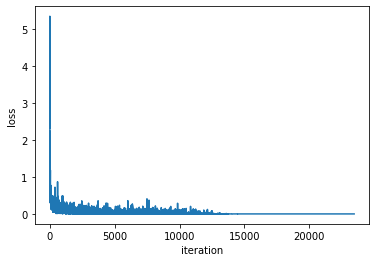

In [13]:
recorder_sgd.plotLosses()

# MLP 2 with  Nesterov

In [14]:
func optFunc(_ model: MyModel) -> SGD<MyModel> { 
    return SGD(for: model, learningRate: 0.4, nesterov: true)}

let learner_nest = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: optFunc, 
                    modelInit: modelInit)

let recorder_nest = learner_nest.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner_nest.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [15]:
try! learner_nest.fit(25)

Epoch 0: [0.13271366, 0.9591]                                                  
Epoch 1: [0.086512186, 0.9722]                                                 
Epoch 2: [0.07691502, 0.9737]                                                  
Epoch 3: [0.100283444, 0.9699]                                                 
Epoch 4: [0.07159021, 0.9792]                                                  
Epoch 5: [0.061131377, 0.9822]                                                 
Epoch 6: [0.06320998, 0.9817]                                                  
Epoch 7: [0.105402954, 0.9725]                                                 
Epoch 8: [0.061935723, 0.9833]                                                 
Epoch 9: [0.06935157, 0.9828]                                                  
Epoch 10: [0.062577285, 0.9835]                                                
Epoch 11: [0.063769735, 0.9845]                                                
Epoch 12: [0.06292782, 0.9847]          

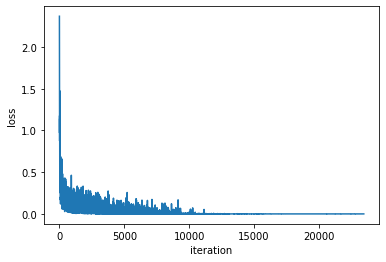

In [16]:
recorder_nest.plotLosses()

# MLP 3 with Nesterov and L1

In [17]:
//Optimizer with Nesterov step and L1 regularizer
func optFunc(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L1()], 
                             stats: [AvgGrad(),PreviousAverageGrad()], 
                             hps: [HyperParams.lr: 0.01])
}

let learner_nest_l1 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: optFunc, 
                    modelInit: modelInit)

let recorder_nest_l1 = learner_nest_l1.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l1.addDelegates([learner_nest_l1.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [18]:
learner_nest_l1.fit(25)

Epoch 0: [0.15907194, 0.9509]                                                  
Epoch 1: [0.0826734, 0.9739]                                                   
Epoch 2: [0.08246678, 0.9764]                                                  
Epoch 3: [0.10238237, 0.9717]                                                  
Epoch 4: [0.102700636, 0.9747]                                                 
Epoch 5: [0.07805958, 0.979]                                                   
Epoch 6: [0.080071025, 0.9803]                                                 
Epoch 7: [0.10137642, 0.9776]                                                  
Epoch 8: [0.08387658, 0.9815]                                                   
Epoch 9: [0.07873538, 0.9842]                                                  
Epoch 10: [0.085704505, 0.9836]                                                
Epoch 11: [0.07866516, 0.985]                                                  
Epoch 12: [0.079245254, 0.9851]        

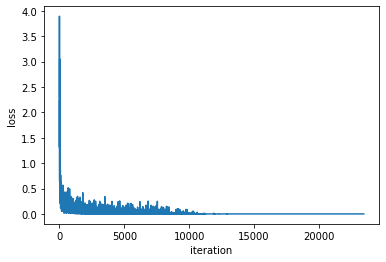

In [19]:
recorder_nest_l1.plotLosses()

# MLP 4 with Nesterov and L2

In [20]:
func SGD_nest_L2(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L2()], 
                             stats: [AvgGrad(),PreviousAverageGrad()], 
                             hps: [HyperParams.lr: 0.01])
}

let learner_nest_l2 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: SGD_nest_L2, 
                    modelInit: modelInit)

let recorder_nest_l2 = learner_nest_l2.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l2.addDelegates([learner_nest_l2.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [21]:
learner_nest_l2.fit(25)

Epoch 0: [0.113647, 0.966]                                                     
Epoch 1: [0.08415924, 0.9719]                                                  
Epoch 2: [0.071176976, 0.9775]                                                  
Epoch 3: [0.07968872, 0.9762]                                                  
Epoch 4: [0.06253215, 0.9803]                                                  
Epoch 5: [0.06856981, 0.9794]                                                  
Epoch 6: [0.066111155, 0.9825]                                                 
Epoch 7: [0.06528852, 0.9815]                                                  
Epoch 8: [0.06649248, 0.982]                                                   
Epoch 9: [0.064171836, 0.9837]                                                 
Epoch 10: [0.06621935, 0.9825]                                                 
Epoch 11: [0.06812059, 0.9827]                                                 
Epoch 12: [0.06616516, 0.9837]         

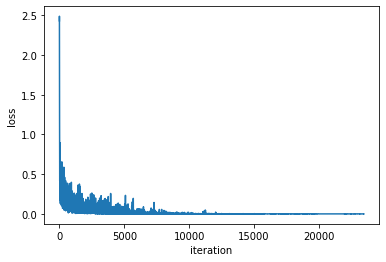

In [23]:
recorder_nest_l2.plotLosses()

In [159]:
let y = Array(0..<recorder_nest_l2.losses.count)
let sgd: Array<Float>     = recorder_sgd.losses.compactMap{$0.scalar}.
let nest: Array<Float>    = recorder_nest.losses.compactMap{$0.scalar}
let nest_l1: Array<Float> = recorder_nest_l1.losses.compactMap{$0.scalar}
let nest_l2: Array<Float> = recorder_nest_l2.losses.compactMap{$0.scalar}


In [177]:
func smooth_curve(points:Array<Float>, factor:Float=0.99) -> Array<Float> {
    var smoothed_points: Array<Float> = Array()
    let x1 = points.first
    smoothed_points.append(x1!)
    var points_ = points.dropFirst()
    for point in points_{
            let previous = smoothed_points.last
            let smth = previous! * factor + point * (1 - factor)
            smoothed_points.append(smth)
    }
        
    return smoothed_points
}
    

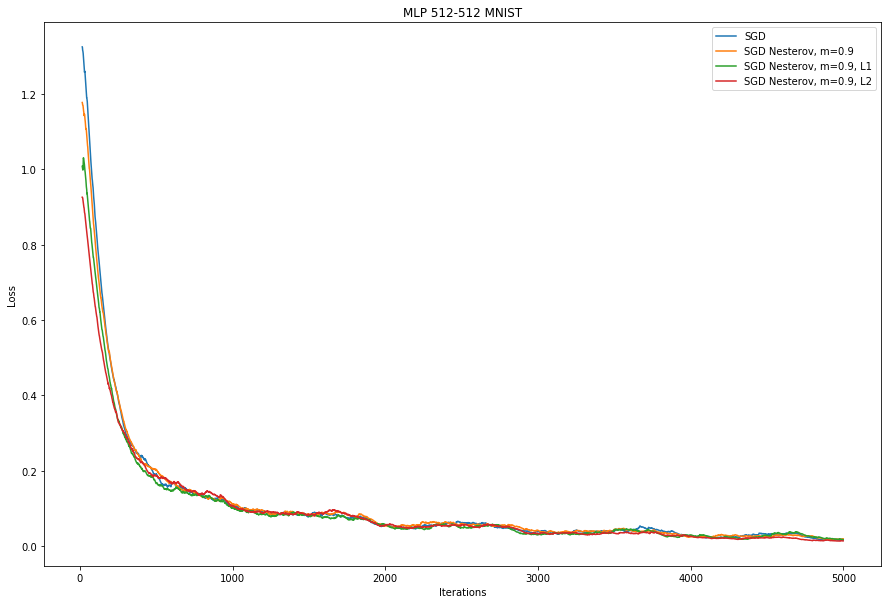

None


In [187]:
plt.figure(figsize: [15, 10])
let i = 15
let n = 5000
let y2 = Array(y[i..<n])
plt.plot(y2,smooth_curve(points: Array(sgd[i..<n])), label:"SGD")
plt.plot(y2,smooth_curve(points: Array(nest[i..<n])), label:"SGD Nesterov, m=0.9")
plt.plot(y2,smooth_curve(points: Array(nest_l1[i..<n])), label:"SGD Nesterov, m=0.9, L1")
plt.plot(y2,smooth_curve(points: Array(nest_l2[i..<n])), label:"SGD Nesterov, m=0.9, L2")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP 512-512 MNIST")
plt.show()